In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.6.0
Tensorflow Probability Version:  0.14.1


In [3]:
# Load the CelebA dataset and split into training and validation sets
data, info = tfds.load('celeb_a', split=['train[:80%]', 'train[80%:]', 'test'], with_info=True)

# Define the image size and batch size
img_size = 64
batch_size = 32
# Define a function to preprocess the images
def preprocess_image(sample):
    image = sample['image']
    image = tf.image.resize(image, size=(img_size, img_size))
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1.0  # Normalize the pixel values to the range [-1, 1]
    return image

# Apply the preprocessing function to the training and validation datasets
train_ds = data[0].map(preprocess_image).shuffle(buffer_size=10000).batch(batch_size)
val_ds = data[1].map(preprocess_image).batch(batch_size)
test_ds= data[2].map(preprocess_image).batch(batch_size)

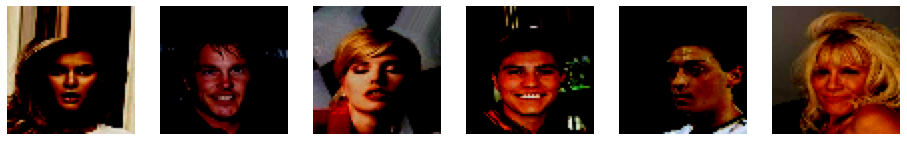

In [4]:
n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image[0])
    axs[j].axis('off')

In [5]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [6]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [7]:
prior = get_prior(num_modes=2, latent_dim=50)
prior

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[50] dtype=float32>

In [8]:
# Define the network

In [9]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [10]:
kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape

In [12]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

In [13]:
encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

In [14]:
encoder.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         5

In [15]:
# Define the decoder network/

In [16]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    return decoder

In [17]:
decoder = get_decoder(latent_dim=50)

In [18]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              208896    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)       

In [19]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [20]:
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [22]:
vae.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100


ValueError: in user code:

    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/cse479/abiswas3/.conda/envs/tensorflow-env/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 64, 64, 3), found shape=(None, None, 64, 64, 3)


In [43]:
test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

624/624 [==============================] - 2s 3ms/step - loss: 0.0025
Test loss: 0.0024751743767410517


In [44]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior.mean())
    return decoding_dist.mean()

In [45]:
n_reconstructions = 7

for all_test_images in test_ds.take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(32, n_reconstructions, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

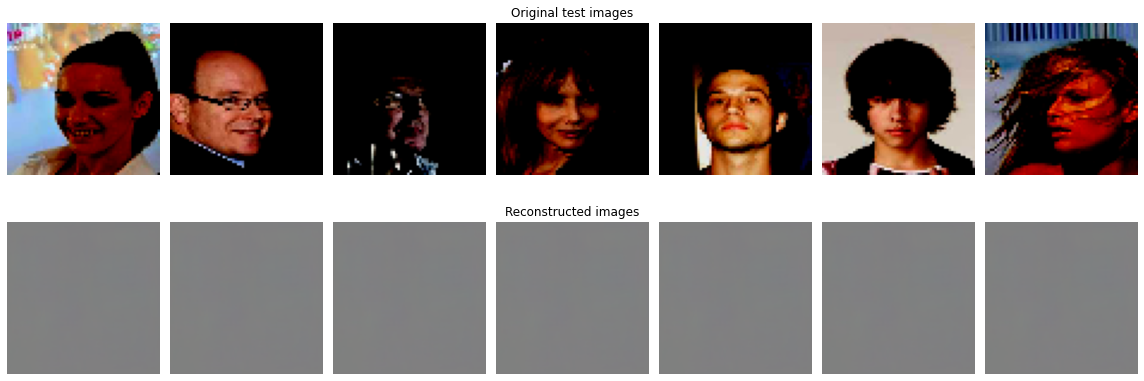

In [47]:
f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")
for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();